# Simulation of High energy physics beam
by: Sharoz Schezwen U2040880D

### <u>Background motivation</u>

Current High-Energy Physics (HEP) simulation of the beams producing certain types of particles are done using Monte-Carlo. An example of this includes the ones used at CERN such as GENIE which can be freely found on Github. When such particles are produced, they are typically assumed to be moving in a predictable pattern based on the total and the kinetic energy they initially posess. This assumption may be quite literally true for some particles which do not interact with other particles when on their way to a detector. However, this may not always be the case.

Therefore, it would be prudent to produce a good counterexample for when such assumptions should not be upheld. In particular, if these particles can interact on their way to a detector, one necessarily needs to assume it will, and the interactions would happen at random. This is the background of this project, in which we will be using a noisy assumption for particles that will undergo intermediate interactions on their way to the detector instead.

### <u>Preliminary Theory</u>

#### Step 1: Computing the number of expected produced particles

HEP simulations typically rely on a very fundamental quantity, which is the number of protons on target (POT). This variable allows a simulation to accurately predict the amount of generated particles. By using this number and the respective decay probability into a particle in consideration, we can obtain the number of particles generated when the protons impinge on a target plate (the target plate is a target for the proton beam, which produces the particle in consideration when this impingement happens). The typical process involve a Monte Carlo generation to simulate the effects of the proton impingement. In this project, this step would be simulated using a similar output visualized in class, which is simply producing a grid of total elements = POT set by the user, and using the Metropolis-Hastings algorithm to randomly get a number for the amount of generated particles following a Gaussian distribution, with the decay probability acting as a cutoff in teh Gaussian distributiony(ie. red grid points are the generated particles, and blue ones are not generated below).

User inputs at this step:
 - The user would provide an input to the expected decay probability to the desired particle
 - The user needs to define the POT to be used as the grid

#### Step 2: Computing the trajectory probability and volume

The next step requires the program to calculate the expected probability that the trajectory of the particle will be in a conical volume that points to the detector at the edge of a sphere. To do this, the program would compute the volume of the cone over the volume of the sphere. The assumption made here is that all the particles come from the same target plate which has the same size, and they are situated at the central region of this sphere. 

The cone needs to have its base covering the whole detector at the edge of the sphere. For simplicity, we assume that the detector is circular. The probability that the trajectory will be in the direction of the detector is the volume of the cone over the volume of the sphere with a radius marked as 'Total Probability' in the diagram below : this radius is from the source to the detector. The simulation would assume that the center of coordinates is at the source.

<p align="center">
<img src="integration_volume.png">

The probability the partices will be within the correct trajectory will therefore be

$\begin{equation}
    Probability = \frac{V_{cone}}{V_{sphere}}
\end{equation}$
$\begin{equation}
    Probability = \frac{\pi r_{detector}^2 l}{4 \pi r_{total}^3}
\end{equation}$
$\begin{equation}
    Probability = \frac{r_{detector}^2 l}{4 r_{total}^3}
\end{equation}$

But this is the analytic expression of the integration. The program will integrate the volume numerically instead for the cone, and assuming the expression of the exact volume is unknown. For the sphere, as it is the total probability, not affected by the trajectory, I have elected to simply use the analytic expression of the sphere. Also, $l$ here is equivalent to $r_{total}$.

User inputs at this step:
 - The user would provide an input to the length from the source to the detector, which acts as the radius of the circle for the total probability in the diagram
 - The user would also input the radius of the circular surface of the cone's base, which is assumed to be the same size as the detector cross section

#### Step 3: Computing the motion of the particles to the detector

The third step involves the simulation of the particles on their way to the detector, with the possibility of random interactions. The actual interactions of the particles depend on a lot of factors that simulations will not be able to reproduce, like the collision of the particles with the air molecules. Therefore, the project would assume that the particles undergo interactions which are random noise additions to the particle trajectories. With this, we can predict the movements with the usage of an ODE numerical method, by assuming a same initial velocity.

User inputs at this step:
 - None

#### Step 4: Computing the trajectory with different magnetic horns

More realistic simulations also have a magnetic horn which focuses charged particles to a detector. Therefore, the random noise acting as the interaction can be reduced by the focusing effects. This will also increase the number of particles at the detector. This section will also use the motion of a charged particle in an EM field.

$\begin{equation}
    \overline{F} = q(\overline{E} + \overline{v} \times \overline{B})
\end{equation}$

The particles 'caught' in the magnetic field (present inside the conical volume) will therefore be expected to precess around the magnetic axis to the detector.

User inputs at this step:
 - The user would provide an input for the charge of the particle







## Assumptions made in the project
 - the detector is facing the base of the cone trajectory
 - The source radiates its decay (which are the particles) outward in all directions equally
 - The detector is positioned to be facing the conical volume, with no tilt angle
 - The interactions undergone is random noise
 - Each of the particles have a set mass (in a better simulation, they can have different particle masses)

===================================================================================================================================================================

===================================================================================================================================================================

In [15]:
### functions and imports
import numpy as np
import matplotlib.pyplot as plt


#### Step 1: Computing the number of expected produced particles

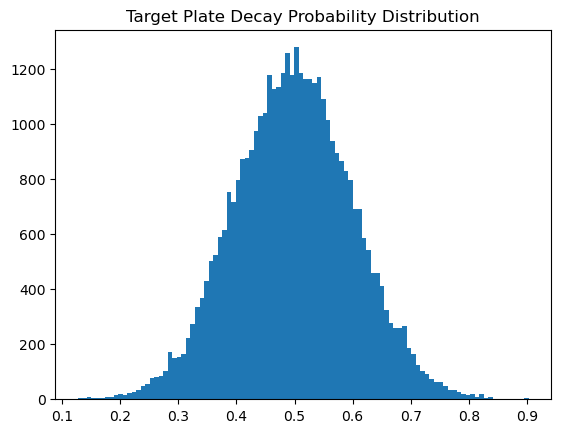

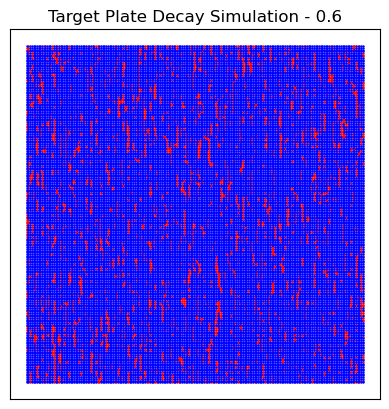

The number of expected decays are : 6362


In [16]:
'''
Grid creation - a square target is assumed, so the grid is square shaped
The target plate is where a proton beam will hit a plate that consists of elements that will produce the particle of interest

We get a range of elements that is distributed according to the MH algorithm and the probability given by the user. 
This is then reshaped into a grid to show the target plate.
The number of decayed particles is then counted based on the cutoff by the decay probabilities

probabilityDecay is the probability of a random decay of the plate into anything, which is set to be 0.5
decayThreshold is the threshold where a decay would be registered as an actual particle in consideration
So 0.5 probability for the plate to decay upon proton impingement, and of that only the ones above decayThreshold variable is expected to decay into the particle we want
'''

rng = np.random.default_rng()     
nSitesxSide = 200 #square of this is the POT
probabilityDecay=0.5
probDens = lambda x: np.exp(-(0.5/(0.1**2))*((x-probabilityDecay)**2)) #a shift in the Gaussian distribution
varPropDens=0.1
decayThreshold=0.6 #this is the proability of the particle decay

def metropolisHastingMarkovChain(probFunct, startingPoint, varianceProposalDensity, numberOfExtractions):
    """
    Produces a Markov Chain with probability density propotional to probFunct
    It will be produced with the Metropolis Hasting algorithm 
    It uses a normal distribution with a variance varianceProposalDensity

    There is a cut to make sure that every candidate generated will not go below 0 or above 1
    
    Parameters
        ----------
        probFunct     : function
            function of one variable proportional to the intended distribution
        startingPoint : float
            initial point for the Markov Chain
        varianceProposalDensity : float
            variance of the normal distribution used as proposal density
        numberOfExtractions : int
            Number of extractions for the Markov chain
            
    Returns
        ----------
        markovChain : numpy array
            returned Markov chain
    """

    #drop 10% of the initial candidates
    for nExtr in range(int(0.1*numberOfExtractions)):
        candidate = np.random.default_rng().normal(startingPoint, varianceProposalDensity, 1)
        
        while candidate<0 or candidate>1.0:
            candidate = np.random.default_rng().normal(startingPoint, varianceProposalDensity, 1)

        if (np.random.rand() <= probFunct(candidate) / probFunct(startingPoint)):
            startingPoint = candidate
            
    markovChain = np.array([startingPoint])

    for nExtr in range(numberOfExtractions-1):
        candidate = np.random.default_rng().normal(markovChain[-1], varianceProposalDensity, 1)
        
        while candidate<0 or candidate>1.0:
            candidate = np.random.default_rng().normal(markovChain[-1], varianceProposalDensity, 1)

        if (np.random.rand() <= probFunct(candidate) / probFunct(markovChain[-1])):
            markovChain = np.append(markovChain,candidate)
        else:
            markovChain = np.append(markovChain,markovChain[-1])
                
    return markovChain

def randomConfigurationMH(nSitesxSide, probabilityDecay=0.5, varPropDens=0.1, num=100**2):
    '''
    A wrapper function for the grid generation using MH. 
    Parameters
        -----
        nSitesxSide : int
            The sides of the grid to generate
        probabilityDecay : float
            midpoint of a Gaussian distribution generated via the MH algorithm
        varPropDens : float
            variance of the normal distribution used as proposal density
        num : int
            Number of extractions for the Markov chain
    Returns
        -----
        A grid reshaped according to the size given by nSitesxSide

    Probability given by the user is the mean of the first iteration

    '''
    grid1d = metropolisHastingMarkovChain(probDens, probabilityDecay, varPropDens, num)
    plt.hist(grid1d,bins = 100)
    plt.title("Target Plate Decay Probability Distribution")
    plt.show()
    return np.reshape(grid1d,(nSitesxSide,nSitesxSide))

def decayGenerator(configuration, decayThreshold):
    '''
    A simple function to visualize the grid
    Parameters
        -----
        configuration : array
            The grid to visualize
        decayThreshold : float
            The threshold for the decay to get the particle in consideration
    
    Returns
        The number of expected decays from the target plate decay into the particle in consideration
    '''

    up   = np.where(configuration >= decayThreshold)
    down = np.where(configuration < decayThreshold)
    plt.scatter(*up, c='red', s=0.6)
    plt.scatter(*down, c='blue',s=0.6)
    plt.gca().set_aspect(1)
    plt.xticks([]); plt.yticks([])
    plt.title("Target Plate Decay Simulation - {}".format(decayThreshold))
    plt.show()

    return (len(up[0]))

numDecays = decayGenerator(randomConfigurationMH(nSitesxSide, probabilityDecay, varPropDens, nSitesxSide**2), decayThreshold)
print("The number of expected decays are :",numDecays)


#### Step 2: Computing the trajectory probability and volume

To numerically integrate the volume, we note the integral that defines the volume of a cone in cartesian coordinates is found by 

$\begin{equation}
    ConicalVolume = \int_{0}^{l} \frac{\pi r_{detector}^2}{l^2}y^2 \,dy 
\end{equation}$

which can be written as above upon changing of variables. We have taken the radius as the $r_{detector}$ because the radius of the base of the cone is assumed to cover the whole surface of the detector at the edge of the ttoal probability sphere. Therefore, the base of the cone is a circle with the same area as a cross section of the detector. With this, the intergal is effectively a one dimensional integral if we have done the math before the numerical integration part. 

For the spherical volume, the integral in spherical coordinates is obtained with

$\begin{equation}
    SphericalVolume = \int_{\phi=0}^{\pi} \int_{\theta=0}^{2\pi} \int_{\rho=0}^{R} \rho^2 sin(\phi) d\rho d\theta d\phi 
\end{equation}$

We can also convert this into Cartesian coordinates. To do that, we must fix the variables one by one and find out the limits for each dimension. The final result, (which should be easier to compute by hand in Spherical coordinates) should be the same for both coordinate system. In Cartesian coordinates, they read:

$\begin{equation}
    SphericalVolume = \int_{-R}^{R} \int_{-\sqrt{R^2 -z^2}}^{\sqrt{R^2 -z^2}} \int_{-\sqrt{R^2 -z^2 -y^2}}^{\sqrt{R^2 -z^2 -y^2}} dx dy dz 
\end{equation}$

As this is not impacted by the trajectory of the particle, we take the most accurate number, which is found by the analytic expression:

$\begin{equation}
    SphericalVolume = \frac{4}{3} \pi r^3
\end{equation}$

with $r$ as the radius of the total probability sphere = length to the detector 

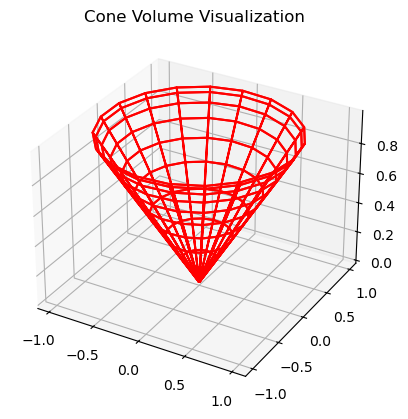

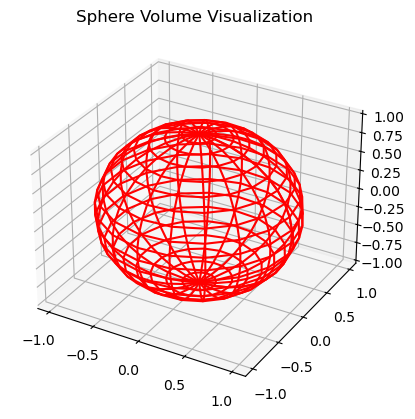

In [17]:
lengthDet = 500 #  = the radius of the total probability sphere
radiusDet = 50

'''
The gaussian quadrature in class was for independent variables. Therefore, for the conical surface, an easy way is to do change of variables first. This was shown above. When this is done, the integration becomes a 1D integration
'''

def compositeGaussIntegration(funcToUse, xmin, xmax, order, nElems):
    """
    Integrates the function within the provided interval 
    with Gauss quadrature of order seleted by the user (max 5)
    
    Parameters
        ----------
        funcToUse  : function
            function of one variable
        xmin  : float 
            lower limit of integration
        xmax  : float
            higher limit of integration
        order : integer
            order of the Gauss integration (max 5)
        nElems : integer
            number of pieces to split the integration domain into

    Returns
        ----------
        integral : float
            definite integral of the function
    """
    
    if order < 1: 
        raise ValueError("The order of Gauss Integration must be positive")
    if order > 5:
        raise NotImplementedError("The maximum implemented order for Gauss Integration is 5")
        
    xs = [ np.array([0.0]),                                            # order 1
          np.array([ -0.577350269189625, 0.577350269189625]),          # order 2
          np.array([-0.7745966692414834, 0.0, 0.7745966692414834]),    # order 3
          np.array([ -0.8611363115940526, -0.3399810435848563, 0.3399810435848563, 0.8611363115940526]), # order 4
          np.array([-0.9061798459386640, -0.5384693101056831, 0., 0.5384693101056831, 0.9061798459386640]) # order 5
    ]
    ws = [np.array([2.0]),
          np.array([1.0000000000000000,1.0000000000000000]),
          np.array([0.5555555555555556, 0.8888888888888888, 0.5555555555555556]),
          np.array([0.3478548451374538, 0.6521451548625461, 0.6521451548625461, 0.3478548451374538]),
          np.array([0.2369268850561891, 0.4786286704993665, 0.5688888888888889, 0.4786286704993665, 0.2369268850561891])
         ]
    
    dxhalf = (xmax-xmin)/(2.0*nElems)
    mesh = np.linspace(xmin,xmax,nElems+1)

    points = np.add.outer(0.5*(mesh[:-1]+mesh[1:]) , dxhalf * xs[order-1]).flatten()
    values = funcToUse(points)
    
    return dxhalf * np.sum(np.tile(ws[order-1],nElems)*values)

from mpl_toolkits import mplot3d
'''Visualization Plots'''
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:20j] #100 points, with stop point inclusive for x, and 80 points with stop points inclusive for y
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)

fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.set_title("Cone Volume Visualization")
ax1.plot_wireframe(x, y, np.sqrt(x ** 2 + y ** 2), color='r') #cone

fig = plt.figure()
ax2 = plt.axes(projection='3d')
ax2.set_title("Sphere Volume Visualization")
ax2.plot_wireframe(x, y, np.cos(v), color='r') #sphere


In [18]:
'''conical volume integration'''
funcConeIntegr = lambda y:(np.pi/(lengthDet**2))*(radiusDet**2) * (y**2)
coneVol = compositeGaussIntegration(funcConeIntegr, 0, lengthDet, 5, 20)
print("The volume of the cone is :", coneVol)


'''spherical volume integration'''
funcSphIntegr = lambda z: np.cos(z)
sphVol = (4/3)*np.pi*lengthDet**3 # compositeGaussIntegration2DSphere(funcSphIntegr, 0, 2*np.pi, 0, np.pi, 5, 20, 20)
print("The volume of the sphere is :", sphVol)


'''Expected Probability'''
expectedTrajectoryProbability = coneVol/sphVol

'''Error Analysis'''
absoluteFunction = radiusDet**2 / (4*lengthDet**2)
print("The total probability for the decay to point in the direction of the detector in percentage is:", expectedTrajectoryProbability*100, "with an error of:", abs(absoluteFunction-expectedTrajectoryProbability))

finalDecayNum = int(numDecays*expectedTrajectoryProbability) #this will be used to get a set of results below
print("The number of expected decays pointing to the detector is:", finalDecayNum)

The volume of the cone is : 1308996.9389957471
The volume of the sphere is : 523598775.5982988
The total probability for the decay to point in the direction of the detector in percentage is: 0.25000000000000006 with an error of: 4.336808689942018e-19
The number of expected decays pointing to the detector is: 15


#### Step 3: Computing the motion of the particles to the detector

The steps to generate the noise to simulate the interactions were inspired from : https://arxiv.org/pdf/1405.3402.pdf

This simulation was done to complement my Final Year Project, which was on Neutrino Physics. In particular, a lot of times neutrinos are assumed to be massless, and therefore they move at really high speeds such that in most practical cases, the initial velocity, computed from its energy, and one step of Euler Forward is enough to illustrate the neutrino movements, if they reach the detector at all. Even a distance of hundreds of meters would produce not much difference in the neutrino movements since it is moving relatively fast. However, this simulation aims to include the interactions in between which is random, and will impact the speed they travel at. This randomness may then affect the trajectory as well. Therefore, the ODE defined for the neutrino's movements must then be changed. To achieve this, we need to construct an equation that incorporates this random interaction in a logical way.

In summary, the trajectory starts with an equation of constant velocity. This velocity realistically has a lot of factors to include, such as the momentum of the decay products (which would be a continuum). Therefore, we assume that it starts with an everage energy of a neutrino of 400 MeV (my FYP deals with a heavier type of neutrinos called sterile neutrinos), which is one of the possible masses. Therefore, we can safely use this energy and use it as a generated neutrino's energy instead, which means that we can now skip the overly complicated step of generating a continuum of momentum distribution for the daughter decay products. In more realistic simulations, which takes a few days to run, we can incorporate this continuum generation as well, but this simulation does not include that naturally because of runtime constraint.

Also, as mentioned above, the neutrinos travel really fast. So any random interaction would not produce that much of an impact because of how little time they have to interact before reaching the detector. But for sterile neutrinos, their heavy mass may allow some time for interaction. I say 'may' because the heavy neutrinos come in a range of energy, and some are lighter, which moves faster, while some are really heavy, which moves far slower. 400 MeV is not small but not very large either.

Regardless, initially, we assume a constant velocity of 

$\begin{equation}
    v = v_{400MeV} = 0.0001*c 
\end{equation}$

where $c = 2.99e8$ is the speed of light.

Now a random interaction can logically be interpreted as a deterrent to the motion. Therefore, I model it as a random addition of noise velocities. The velocities come in 3 dimensions, left-right, up-down and forward-backwards.

$\begin{equation}
    v_{t} = v_0 + A*v_{up} + B*v_{left} + C*v_{forwards \leq v_0 }
\end{equation}$

where A,B and C are random variables. $v_0$ from the previous iteration would also therefore have a up, left and forward value. This is done with the Euler forward method. Initially, I planned to include the Runge-Kutta 4 method, but obtained not much difference. I theorize it is because of the linear form of the velocity function and also the very quick speed of the particles. 

Finally, to visualize the plot, we make it so that the forward-backwards axis points towards the detector, the left-right as the x-axis, and the up-down values are values in the z-axis. This is only in the plots, the computations all assume that the x-axis as the left-right movement, the y-axis as the up-down movement and the z-axis as the forwards-backwards movement. The difference is because usually in HEP simulations the z-axis is taken to be the direction to teh detector (forwards-backwards in this case) but since I am plotting the trajectoris, it is mroe understandable in my opinion to change the order.

To further enhance the capabilities, one can also include a section of the surface from the total probability sphere which will act as the detector entrance. Therefore, due to the random noise, if the particle does not cross this section of the surface, it is assumed to not enter the detector and therefore not detected. The figure below provides an illuminating visualization in 2 dimensions.

<p align="center">
<img src="particleRandom.png">

Where the red box is the detector entrance, the black line is a random particle motion, and the blue line is the disance from the source to the detector.

In the plots I produced, I drew a circle to show the detector entrance. This is not correct in the Forward-Backwards axis because the very fast movement of the particle in this axis would show that the detector is almost at the same place as the source, if I put it in the correct place. The particles can move about $10^6$ meters, while the detector is at $500$ meters away from the source. So, I displaced it a bit for better clarity in the plots.


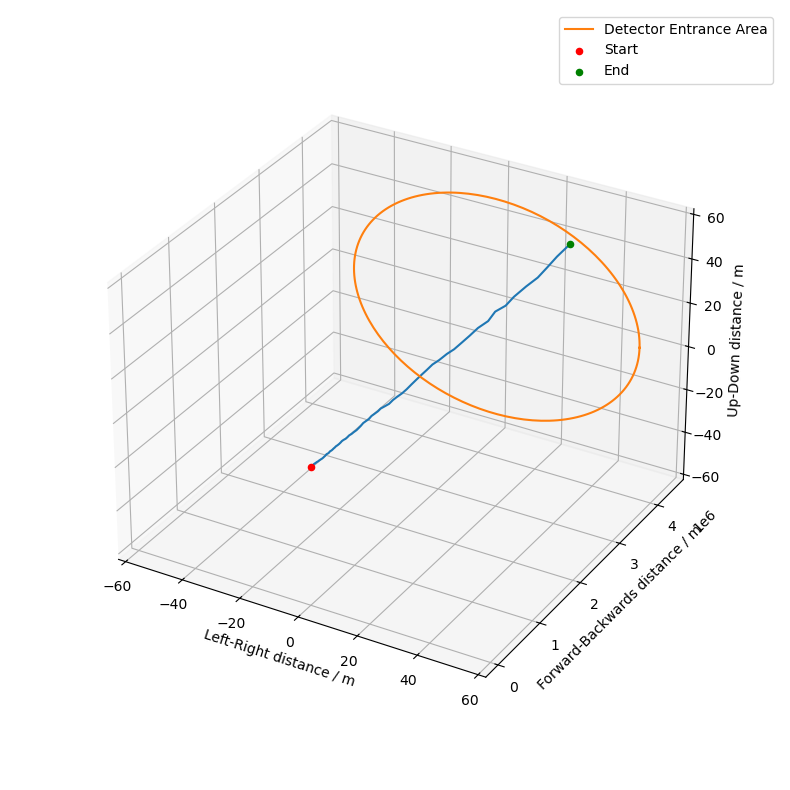

'Uncomment here to view the noise in 2Dimensions'

In [20]:
sol=2.99e8 # for calculating the speed of the forward mvoement of the particel in consideration
'''noise generation - set to have a  limit of 0 to .005 for forward movements (it is illogical to have interactions make the velocity go 0.0001c backwards, or faster forwards) 
   and 0 to .8 for up and down movements, and left and right movements
'''
def noise(l0, u0, f0):
    '''
    Function to compute the noise at intermediary steps
    Parameters:
        -----
        l0 : float
            Velocity in the left-right (x-axis) direction
        u0 : float
            Velocity in the up-down (y-axis) direction
        f0 : float
            Velocity in the forwards-backwards (z-axis) direction
    '''
    return np.random.uniform(low=-0.8,high=0.8)*l0,  np.random.uniform(low=-0.8,high=0.8)*u0, np.random.uniform(low=-0.005, high=0)*f0


'''Trajectory Computation'''
def eulerForwardModified(operator, initCond, initTime, finalTime, nSteps):
    '''
    Trajectory computation function
    Parameters
        -----
        operator : function
            The velocity function
        initCond : array
            The initial conditions in all 3 directions
        initTime : float
            The initial time
        finalTime : float
            the final time 
        nSteps : int
            number of steps to compute for the Euler Forward method

    '''
    times = np.linspace(initTime, finalTime, nSteps+1)
    dt = times[1] - times[0]
    solutUp = [initCond[0]]
    solutLeft = [initCond[1]]
    solutForward = [initCond[2]]

    for t in times[:-1]:

        derivativeBeginningUp = operator(t, solutUp[-1])
        derivativeBeginningLeft = operator(t, solutLeft[-1])
        derivativeBeginningForward = operator(t, solutForward[-1])

        noiseL, noiseU, noiseF  = noise(derivativeBeginningLeft,derivativeBeginningUp,derivativeBeginningForward)

        attemptedStepUp = solutUp[-1] + dt * (derivativeBeginningUp)
        attemptedStepLeft = solutLeft[-1] + dt * (derivativeBeginningLeft)
        attemptedStepForward = solutForward[-1] + dt * (derivativeBeginningForward)

        approximateDerivativeEndUp  = operator(t + dt, attemptedStepUp)
        approximateDerivativeEndLeft  = operator(t + dt, attemptedStepLeft)
        approximateDerivativeEndForward  = operator(t + dt, attemptedStepForward)

        #this is done so that the new composite derivative is also impacted by noise, but generated based on the attempted step
        noiseL, noiseU, noiseF  = noise(approximateDerivativeEndLeft,approximateDerivativeEndUp,approximateDerivativeEndForward)
        stepToReturnUp = solutUp[-1] + dt * ((derivativeBeginningUp + approximateDerivativeEndUp)/2 + noiseU)
        stepToReturnLeft = solutLeft[-1] + dt * ((derivativeBeginningLeft + approximateDerivativeEndLeft)/2 + noiseL)
        stepToReturnForward = solutForward[-1] + dt * ((derivativeBeginningForward + approximateDerivativeEndForward)/2 + noiseF)
        
        solutUp.append(stepToReturnUp)
        solutLeft.append(stepToReturnLeft)
        solutForward.append(stepToReturnForward)
   
    return times, np.array(solutLeft), np.array(solutUp), np.array(solutForward)

'''The Detector acceptance function and the plotting of the trajectories in 3 dimensions or 2 dimensions'''
def acceptance(finPos):
    '''
    The function to find out if the particle ever gets inside the detector, or if they are not
    Parameters
        -----
        finPos : array
            Final position of the particle, for checking if it is ever inside the detector volume or not.
    Returns
        -----
        int
            0 if False and 1 if the True (particle goes inside the detector)
    '''
    if (np.sqrt(finPos[0]**2+finPos[1]**2) <=radiusDet) & (finPos[2]>=lengthDet):
        return 1
    else:
        return 0

def trajectoryPlot(resultEF):
    '''
    The function to plot the trajectory of the particles simulated. The plots here are slightly changed for clarity. the x axis is the left-right, the y-axis is the forwards-backwards, and the z-axis is the up-down distance instead.
    Only the plots are plotted this way because it looks nicer in my opinion, but all the computations are all done in the correct order.
    Parameters
        -----
        resultEF : 2D array
            Positions of the particle in all 3 dimensions
    '''
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes( projection = '3d')

    #Detector entrance area visualization - not rescaled to forward backward distance because the particle is moving too fast
    theta = np.linspace(0, 2 * np.pi, 201)
    y = radiusDet*np.cos(theta)
    z = radiusDet*np.sin(theta)

    ax.plot(resultEF[0], resultEF[2], resultEF[1])
    ax.plot(y,y+finPos[2],z, label='Detector Entrance Area')

    ax.scatter(resultEF[0,0],resultEF[2,0],resultEF[1,0], color = 'r', label="Start")
    ax.scatter(resultEF[0,-1],resultEF[2,-1],resultEF[1,-1], color = 'g', label="End")

    ax.set_zlabel("Up-Down distance / m")
    ax.set_xlabel("Left-Right distance / m")
    ax.set_ylabel("Forward-Backwards distance / m")
    ax.set_xlim([-60,60])
    ax.set_zlim([-60,60])
    
    ax.set_box_aspect(None, zoom=0.85)

    plt.legend()
    plt.show()

functionMove = lambda t, y: y #velocity is y, then multiplied by t to get the distance in each step
timesEulerMod, positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward  = eulerForwardModified(functionMove, [0.25,0.25,0.0001*sol], 0, 5, 100)

resultEF = np.array((positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward))
inPos = np.array((resultEF[0,0],resultEF[1,0],resultEF[2,0]))
finPos = np.array((resultEF[0,-1],resultEF[1,-1],resultEF[2,-1]))

#for each event, check if the events are accepted or not - return the index of the event that are eccepted
if acceptance(finPos) == 1:
    trajectoryPlot(resultEF)

'''Uncomment here to view the noise in 2Dimensions'''
# def plotterEuler(t,p,l):
#     plt.clf()
#     plt.plot(t, p, label =l)
#     plt.scatter(t, p)
#     plt.legend()
#     plt.show()

# plotterEuler(timesEulerMod, positionsEulerMUp,"Euler modified up" )
# plotterEuler(timesEulerMod, positionsEulerMLeft, "Euler modified left")
# plotterEuler(timesEulerMod, positionsEulerMForward, "Euler modified forward")



#### Step 4: Computing the trajectory with different magnetic horns

While in the previous section, we have estimated that the cone volume over the spherical volume would make the probability of a particle heading towards, and therefore be detected at the detector, there might be cases for when the random noise makes the decayed particles fall out of the conical trajectory and miss the detector.

To combat this, we can implement a magnetic horn to minimize the effect of the random noise (random interactions along the trajectory of each particles). This horn would essentially produce a pulling effect to the particles within its magnetic field, making these particles precess along the magnetic axis. The particles will also then go more towards the center of the detector. The magnetic axis is assumed to be pointing to the center of the detector for this reason.

The equation in question is:

$\begin{equation}
    \overline{F} = q(\overline{v} \times \overline{B})
\end{equation}$

as there are no electric filds $\overline{E}$ assumed. This is the final enhancement to this simulation and will take in a signed real number as the charge.




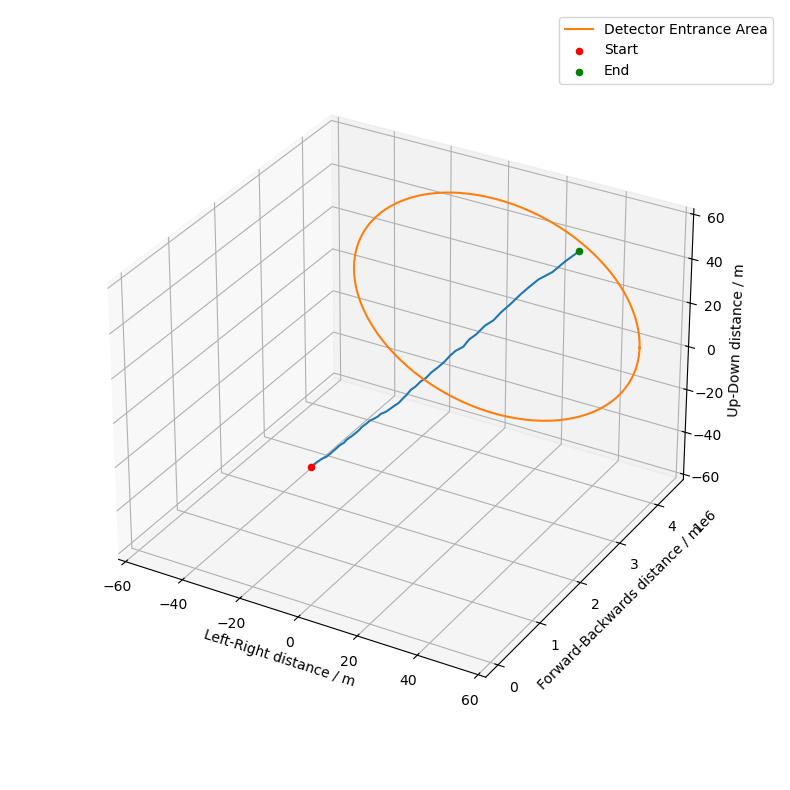

In [23]:
'''As the trajectory is taken in steps, the magnetic field strength and the particle charge cannot be made too high otherwise in between the steps the particle will have moved by a lot'''
particleCharge = 1 #-1, 2, -2 etc
activatedHorn = ['pos'] #positive will attract positive particles
Bz = 1

#horn definition
def eulerForwardHornModified(operatorMove, operatorHorn, initCond, initTime, finalTime, nSteps):
    '''
    Trajectory computation function
    Parameters
        -----
        operatorMove : function
            The velocity function
        operatorHorn : function
            The horn acceleration function
        initCond : array
            The initial conditions in all 3 directions
        initTime : float
            The initial time
        finalTime : float
            the final time 
        nSteps : int
            number of steps to compute for the Euler Forward method

    '''
    times = np.linspace(initTime, finalTime, nSteps+1)
    dt = times[1] - times[0]
    
    solutUp = [initCond[0]]
    solutLeft = [initCond[1]]
    solutForward = [initCond[2]]

    for t in times[:-1]:

        derivativeBeginningUp = operatorMove(t, solutUp[-1]) #y axis
        derivativeBeginningLeft = operatorMove(t, solutLeft[-1]) #x axis
        derivativeBeginningForward = operatorMove(t, solutForward[-1])

        attemptedStepUp = solutUp[-1] + dt * (derivativeBeginningUp)
        attemptedStepLeft = solutLeft[-1] + dt * (derivativeBeginningLeft)
        attemptedStepForward = solutForward[-1] + dt * derivativeBeginningForward

        approximateDerivativeEndUp  = operatorMove(t + dt, attemptedStepUp)
        approximateDerivativeEndLeft  = operatorMove(t + dt, attemptedStepLeft)
        approximateDerivativeEndForward  = operatorMove(t + dt, attemptedStepForward)

        #this is done so that the new composite derivative is impacted by noise, but generated based on the attempted step
        noiseL, noiseU, noiseF = noise(approximateDerivativeEndLeft,approximateDerivativeEndUp,approximateDerivativeEndForward)
        hornVel = operatorHorn(t + dt, approximateDerivativeEndLeft, approximateDerivativeEndUp)

        stepToReturnUp = solutUp[-1] + dt * ((derivativeBeginningUp + approximateDerivativeEndUp)/2 + noiseU) + (hornVel[1])/(2) * (dt**2) #horn acceleration
        stepToReturnLeft = solutLeft[-1] + dt * ((derivativeBeginningLeft + approximateDerivativeEndLeft)/2 + noiseL) + (hornVel[0])/(2) * (dt**2)
        stepToReturnForward = solutForward[-1] + dt * ((derivativeBeginningForward + approximateDerivativeEndForward)/2 + noiseF)
        
        solutUp.append(stepToReturnUp)
        solutLeft.append(stepToReturnLeft)
        solutForward.append(stepToReturnForward)
   
    return times, np.array(solutLeft), np.array(solutUp), np.array(solutForward)

functionHorn = lambda t, vx,vy : [particleCharge*(vy*Bz),particleCharge*(vx*Bz)] #newFx = d (Leftvelocity) /dt, newFy = d (Upvelocity) /dt
functionMove = lambda t, y: y #velocity is y, then multiplied by t to get the distance in each step
timesEulerMod, positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward  = eulerForwardHornModified(functionMove, functionHorn, [0.25,0.25,0.0001*sol], 0, 5, 100)

resultEF = np.array((positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward))
inPos = np.array((resultEF[0,0],resultEF[1,0],resultEF[2,0]))
finPos = np.array((resultEF[0,-1],resultEF[1,-1],resultEF[2,-1]))


if acceptance(finPos) == 1:
    trajectoryPlot(resultEF)


## Simulation Process
Below are examples for running of the simulations

In [46]:
import matplotlib.lines as mlines

'''Legend elements'''
b_line = mlines.Line2D([], [], color='b', linestyle='solid',markersize=10, label='Detector entrance Visualization')
g_dot = mlines.Line2D([], [], color='g', marker='o', linestyle='None',markersize=10, label='End')
r_dot = mlines.Line2D([], [], color='r', marker='o', linestyle='None',markersize=10, label='Start')

def checkInputs(nSitesxSide,decayThreshold,lengthDet,radiusDet,particleCharge,magneticFieldStrength,timeToDetector, nsteps):
    '''
    Function to be used to check for the corect inputs, and correct them if needed in the main simulation function below
    '''
    try:
        nSitesxSide = int(nSitesxSide)
        decayThreshold = float(decayThreshold)
        lengthDet = float(lengthDet)
        radiusDet = float(radiusDet)
        particleCharge = int(particleCharge)
        magneticFieldStrength = float(magneticFieldStrength)
        timeToDetector  = float(timeToDetector)
        nsteps = int(nsteps)

        return nSitesxSide,decayThreshold,lengthDet,radiusDet,particleCharge,magneticFieldStrength,timeToDetector, nsteps
    except:
        raise TypeError("Incorrect inputs, please rerun with the correct values and types.")

def runMain(nSitesxSide,decayThreshold,lengthDet,radiusDet,particleCharge,activatedHorn,magneticFieldStrength,timeToDetector, nsteps, detectorDisplacement=4e6):
    '''
    Main simulation function
    The number of the generated decays with the MH algorithm is multiplied by the trajectory probability to obtain the number of simulations to do that will be pointing towards teh detector.
    Then from here, the noise and the horn inclusion will produce a set of particles that will be detected based on the acceptance() function.
    Parameters
        -----
        nSitesxSide : int
            The sides for the grid in the target plate decay
        decayThreshold : float
            the decay threshold for the particle in consideration
        lengthDet : float
            length from the source to the detector, also the radius of the total probability sphere
        radiusDet : float
            radius of the detector cross section
        magneticFieldStrength : float
            Magnetic Field strength in the z direction for the horn acceleration function
        particleCharge : signed int
            Particle charge for the Horn acceleration function
        timeToDetector : float
            the final time, initial time is automatically set to zero
        nsteps : int
            number of steps to compute for the Euler Forward method
        detectorDisplacement : float
            The distance to displace the detector in the plots
    '''
    nSitesxSide,decayThreshold,lengthDet,radiusDet,particleCharge,magneticFieldStrength,timeToDetector, nsteps = checkInputs(nSitesxSide,decayThreshold,lengthDet,radiusDet,particleCharge,magneticFieldStrength,timeToDetector, nsteps)
    
    functionHorn = lambda t, vx,vy : [particleCharge*(vy*magneticFieldStrength),particleCharge*(vx*magneticFieldStrength)]
    functionMove = lambda t, y: y

    numDecays = decayGenerator(randomConfigurationMH(nSitesxSide, probabilityDecay, varPropDens, nSitesxSide**2), decayThreshold)
    
    funcConeIntegr = lambda y:(np.pi/(lengthDet**2))*(radiusDet**2) * (y**2)
    coneVol = compositeGaussIntegration(funcConeIntegr, 0, lengthDet, 5, 20)
    sphVol = (4/3)*np.pi*lengthDet**3

    expectedTrajectoryProbability = coneVol/sphVol
    finalDecayNum = int(numDecays*expectedTrajectoryProbability)
    print("The number of expected decays pointing to the detector is:", finalDecayNum)

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes( projection = '3d')
    #Detector entrance area visualization - not rescaled to forward backward distance because the particle is moving too fast
    theta = np.linspace(0, 2 * np.pi, 201)
    y = radiusDet*np.cos(theta)
    z = radiusDet*np.sin(theta)
    ax.plot(y,y+detectorDisplacement,z, color='b')
    ax.set_zlabel("Up-Down distance / m")
    ax.set_xlabel("Left-Right distance / m")
    ax.set_ylabel("Forward-Backwards distance / m")
    ax.set_xlim([-60,60])
    ax.set_zlim([-60,60])
    ax.set_box_aspect(None, zoom=0.85)

    for i in range(finalDecayNum):
        
        timesEulerMod, positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward  = eulerForwardModified(functionMove, [0.25,0.25,0.0001*sol], 0, timeToDetector, nsteps)
        resultEF = np.array((positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward))
        inPos = np.array((resultEF[0,0],resultEF[1,0],resultEF[2,0]))
        finPos = np.array((resultEF[0,-1],resultEF[1,-1],resultEF[2,-1]))
        
        if acceptance(finPos) == 1:
            ax.plot(resultEF[0], resultEF[2], resultEF[1])
            ax.scatter(resultEF[0,0],resultEF[2,0],resultEF[1,0], color = 'r')
            ax.scatter(resultEF[0,-1],resultEF[2,-1],resultEF[1,-1], color = 'g')
    
    plt.title("Euler Forward without Horns")
    plt.legend(handles=[b_line,g_dot,r_dot], loc=0)
    plt.show()
    plt.clf()

    """I separated the plots to make two sets because I want the plots to be on different canvas"""

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes( projection = '3d')
    #Detector entrance area visualization - not rescaled to forward backward distance because the particle is moving too fast
    theta = np.linspace(0, 2 * np.pi, 201)
    y = radiusDet*np.cos(theta)
    z = radiusDet*np.sin(theta)
    ax.plot(y,y+detectorDisplacement,z, color='b')
    ax.set_zlabel("Up-Down distance / m")
    ax.set_xlabel("Left-Right distance / m")
    ax.set_ylabel("Forward-Backwards distance / m")
    ax.set_xlim([-60,60])
    ax.set_zlim([-60,60])
    ax.set_box_aspect(None, zoom=0.85)

    for i in range(finalDecayNum):

        timesEulerMod, positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward  = eulerForwardHornModified(functionMove, functionHorn, [0.25,0.25,0.0001*sol], 0, timeToDetector, nsteps)
        resultEF = np.array((positionsEulerMLeft, positionsEulerMUp, positionsEulerMForward))
        inPos = np.array((resultEF[0,0],resultEF[1,0],resultEF[2,0]))
        finPos = np.array((resultEF[0,-1],resultEF[1,-1],resultEF[2,-1]))

        if acceptance(finPos) == 1:
            ax.plot(resultEF[0], resultEF[2], resultEF[1])
            ax.scatter(resultEF[0,0],resultEF[2,0],resultEF[1,0], color = 'r')
            ax.scatter(resultEF[0,-1],resultEF[2,-1],resultEF[1,-1], color = 'g')

    plt.title("Euler Forward with Horns")
    plt.legend(handles=[b_line,g_dot,r_dot], loc=0)
    plt.show()
    plt.clf()



## Preliminary Runs

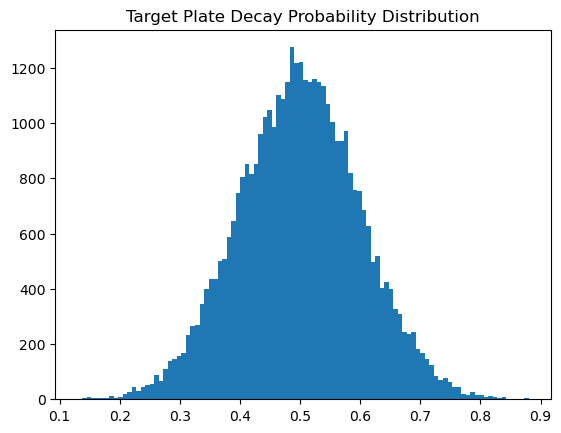

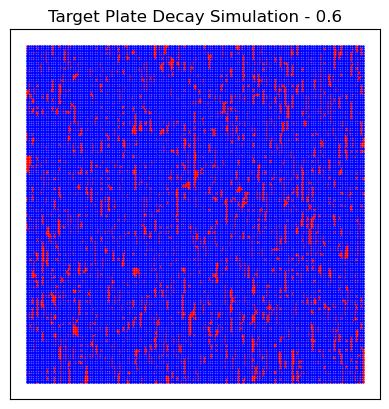

The number of expected decays pointing to the detector is: 15


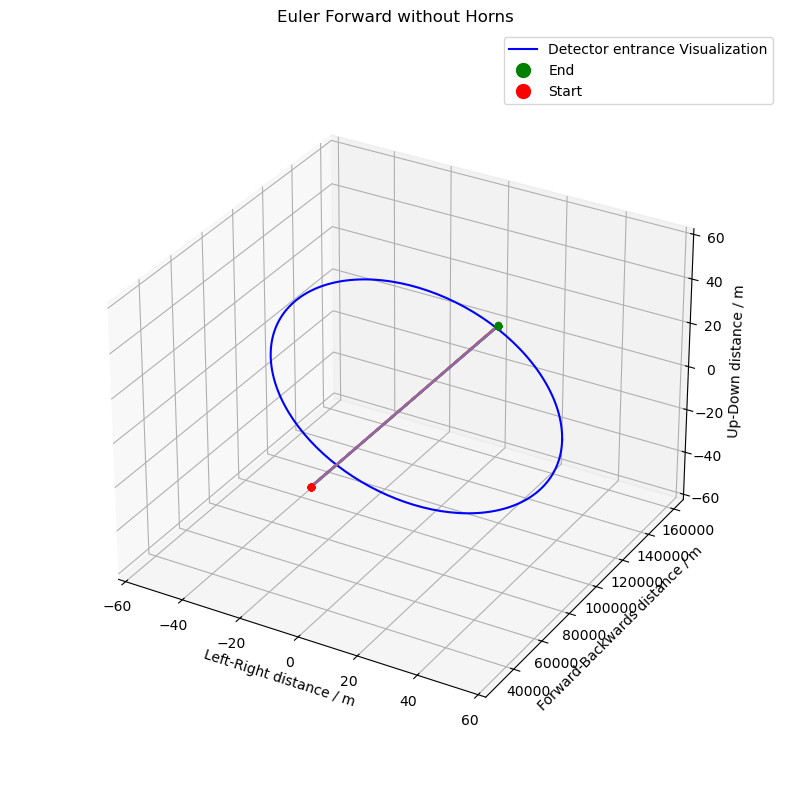

<Figure size 640x480 with 0 Axes>

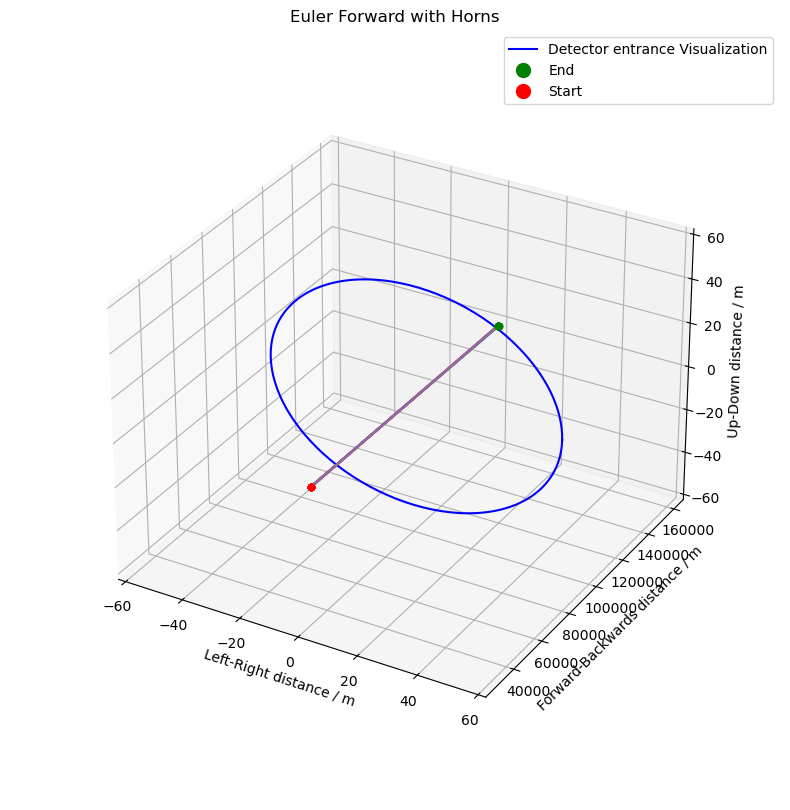

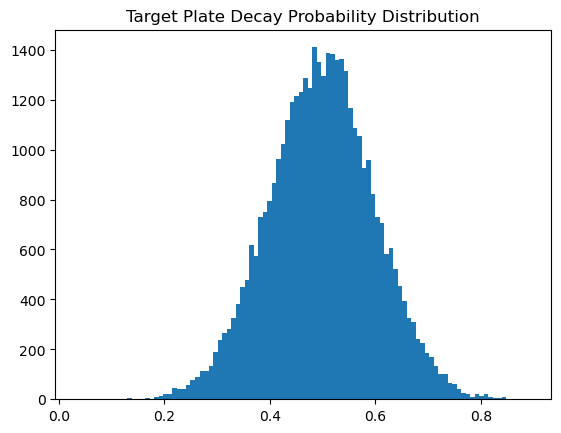

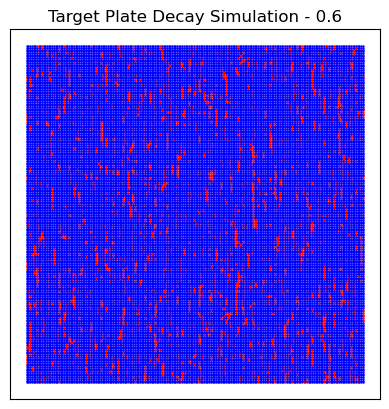

The number of expected decays pointing to the detector is: 15


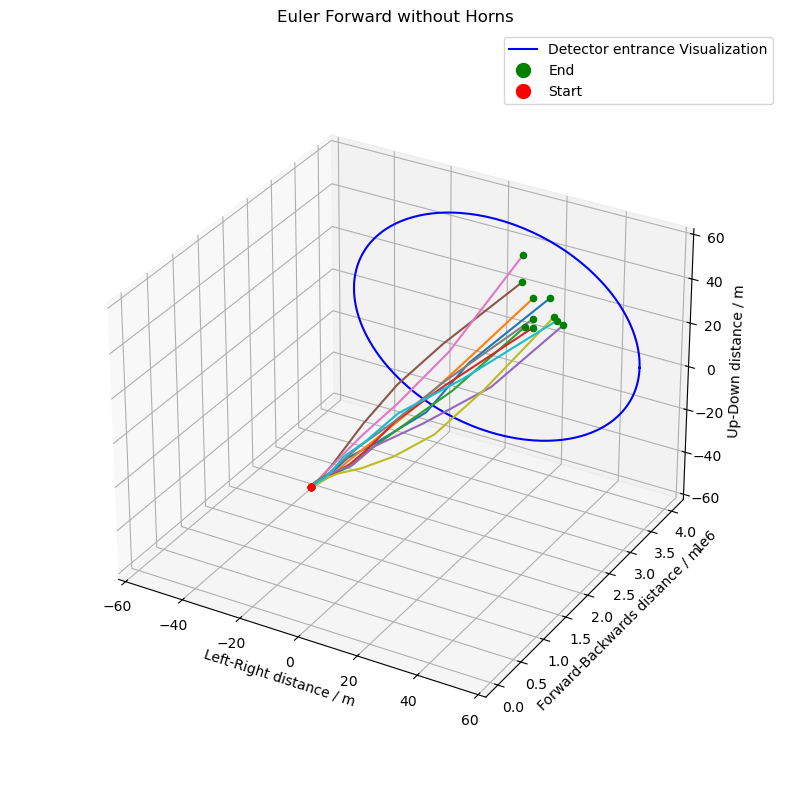

<Figure size 640x480 with 0 Axes>

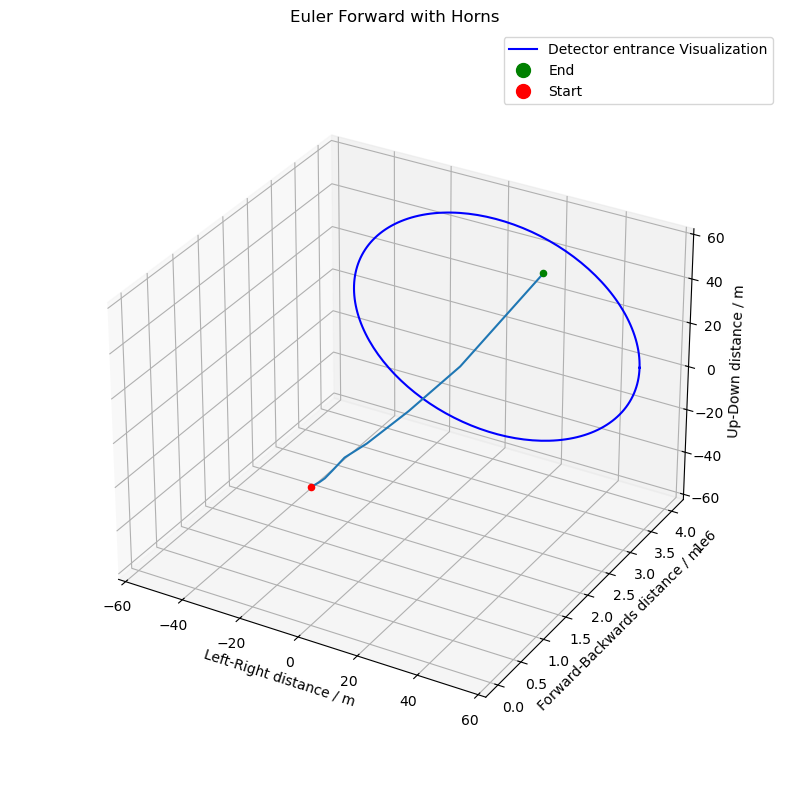

<Figure size 640x480 with 0 Axes>

In [52]:
#Preliminary Run -  when the time is too small, too little time for it to precess, generally the number of detections with horns are lesser
'''The particles will be seen to be more bunched because of the little time it can change in the left-right and up-down directions, the horns may generate lesser detections as well, and the particles appear to be moving in a straight line
'''
sol=2.99e8
runMain(nSitesxSide=200,decayThreshold=0.6,lengthDet=500,radiusDet=50,particleCharge=1,activatedHorn=1,magneticFieldStrength=1,timeToDetector=1.67, nsteps=100, detectorDisplacement=1e5)



#Preliminary Run - when the steps are too little, too large time for the particles to move such that they would fall outside the detector area when they reach it
'''Below is when the number of steps are smaller. We can see that a larger step (lower number of steps within the same time domain) allows for much larger movement of the precession, 
which produces less detections instead for the simulations with the horns. This is incorrect")
'''
print("\n\n\n")
print("="*20)
runMain(nSitesxSide=200,decayThreshold=0.6,lengthDet=500,radiusDet=50,particleCharge=1,activatedHorn=1,magneticFieldStrength=1,timeToDetector=5, nsteps=10)


## Example Runs

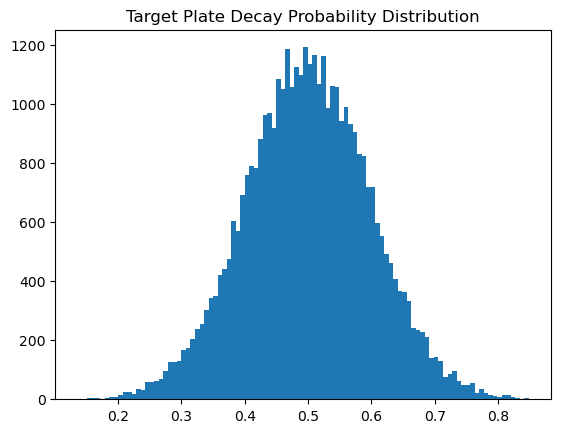

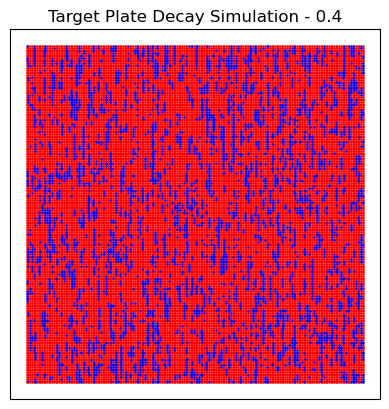

The number of expected decays pointing to the detector is: 84


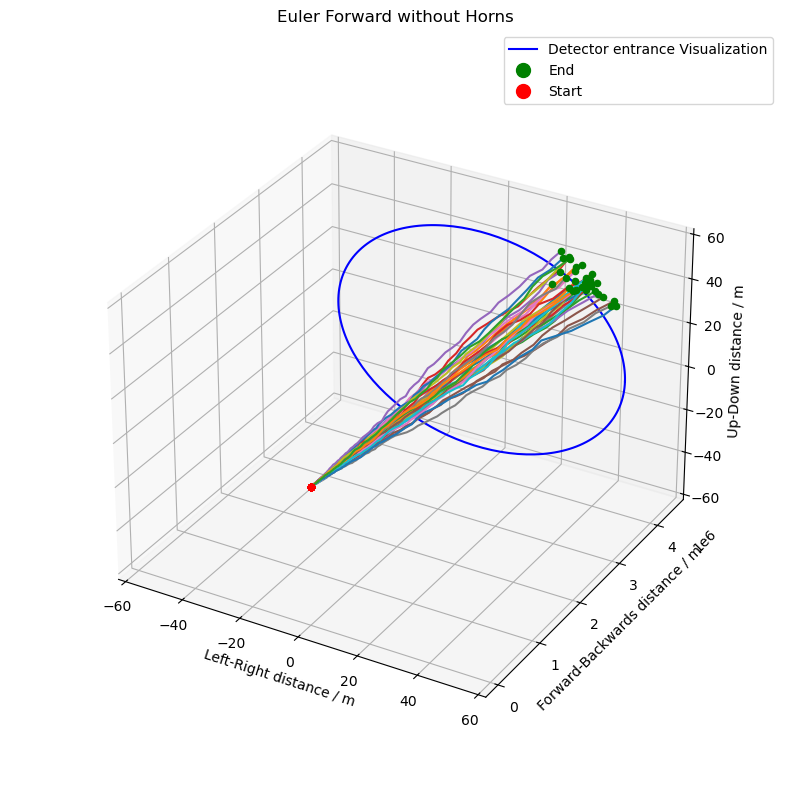

<Figure size 640x480 with 0 Axes>

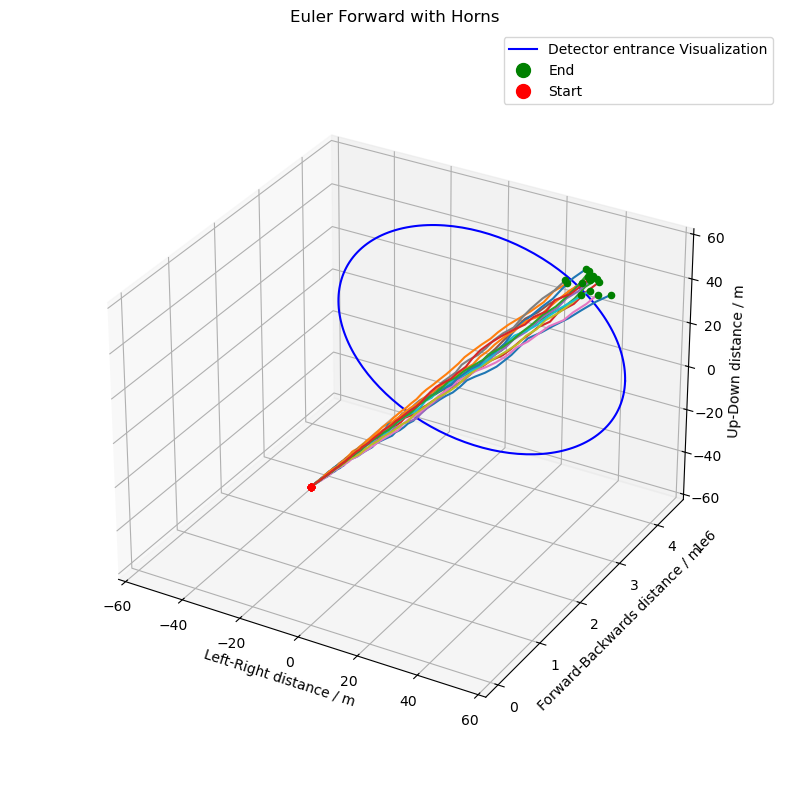

'\nA good number of steps would be 1000, to show an increase in the number of detections with horns (upon running it more times, sometimes the result will randomly be lesser) but then the impact of noise is less seen.\nWith less steps, the more refined movements resulting from the horns can be seen (the detections events are more bunched together)\n'

<Figure size 640x480 with 0 Axes>

In [56]:
#Example Run 1
runMain(nSitesxSide=200,decayThreshold=0.4,lengthDet=500,radiusDet=50,particleCharge=1,activatedHorn=1,magneticFieldStrength=1,timeToDetector=5, nsteps=100)
'''
A good number of steps would be 1000, to show an increase in the number of detections with horns (upon running it more times, sometimes the result will randomly be lesser) but then the impact of noise is less seen.
With less steps, the more refined movements resulting from the horns can be seen (the detections events are more bunched together)
'''

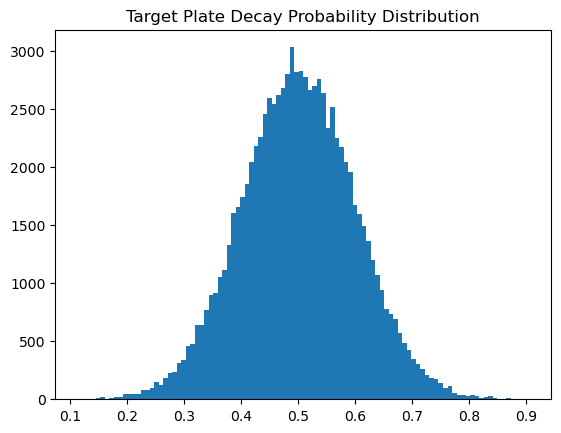

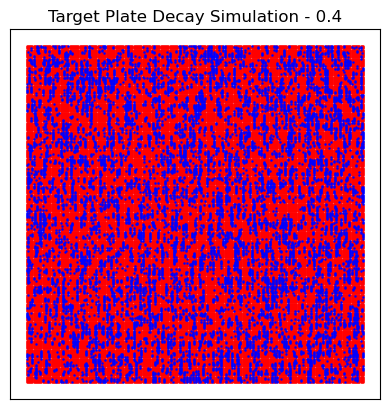

The number of expected decays pointing to the detector is: 189


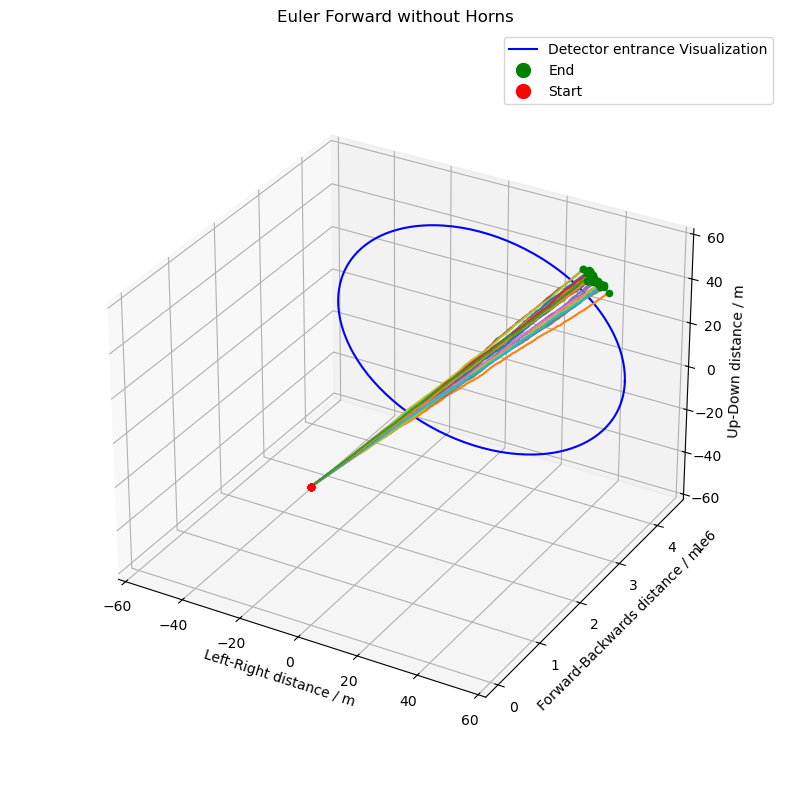

<Figure size 640x480 with 0 Axes>

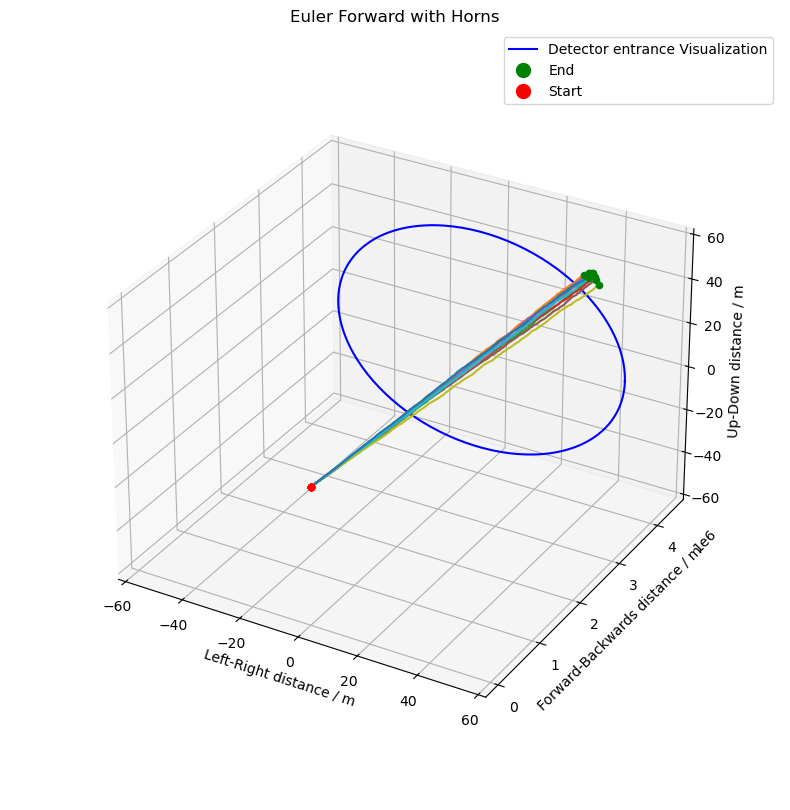

'\nLarge statistics (more target plate coordinates with higher nSitesxSide, more steps, and more iterations with lower decayThreshold) takes about 15 seconds to run on my computer but the bunching due to the horns are much more obvious.\nBut the effect of noise is less seen as the number of steps is larger\n'

<Figure size 640x480 with 0 Axes>

In [57]:
#Example Run 2
runMain(nSitesxSide=300,decayThreshold=0.4,lengthDet=500,radiusDet=50,particleCharge=1,activatedHorn=1,magneticFieldStrength=1,timeToDetector=5, nsteps=1000)

'''
Large statistics (more target plate coordinates with higher nSitesxSide, more steps, and more iterations with lower decayThreshold) takes about 15 seconds to run on my computer but the bunching due to the horns are much more obvious.
But the effect of noise is less seen as the number of steps is larger
'''

## Conclusions

Firstly, the trajectory always seem to be pointing into the top right of the detector. This is because the initial conditions are assuming a right and upwards velocity (the velocity is named left-right velocity, but the plotting is done with right as positive, Since the intial condition for the left-right velocity is positive, this bias is expected). In the future, more dimensions of left and down can be implemented instead of having a negative right = left. Or, instead of $\textbf{multiplying}$ the velocity to a random number that makes up the noise. We can instead make the $\textbf{addition}$ of random number into the velocity. This way, the initial conditions can be 0 for both the left-right and the up-down movement to avoid this bias.

The addition of the horn makes the trajectory just only a slight bit more curly when I ran it time and time again. This could be because the forward mvoements are too rapid to show the precession around the magnetic axis. But at the same time, we can see that the trajectories are more clustered together with the horns compared to without horns. I have shown some wrong cases of too small timeframe, or when the number of steps are too low. This would give most of the time wrong solutions to when the magnetic horns are included. But since the movement is random, there may be results which may seem correct, but is not. It is advisable to stick to a good balance of sufficient time for intermediate movements, and higher steps to not make the intermediate steps move out of the conical volume that is heading towards the detector.

For $ 4 \times 10^4$ POT (nSitesxSide = 200), this simulation got about 16 events. Typical simulations are on the order of $10^6 - 10^8$ POTs, which would give around $1600 - 160000$ detection events with this simulation. This is actually slightly more than what would be obtained from the simulations done in my FYP, which I can get detection events of $200 - 120000$, depending on the statistics. Therefore, although this simulation is quite simple, and uses the MH algorithm to compute the target plate decay events, the maximum number of detection events are comparable.

Some of the errors that is inherent in the simulation is of course the computation of the conical volume using numerical integration. I also think that the pseudo-randomness of the rng generator may induce some errors. In this simulation, the detection events with and without horns are from separated functions, which would mean they have different noise. I aim to combine them into one function to get a more fair depiction that may arise from any of the errors in the rng function in the future.

=========================================================================================================================================

=========================================================================================================================================

Overall in this project I have
 - implemented Markov chain into predicting a decay probability and added a threshold cut for the possible values generated
 - included random noise into the ODE's we learnt in class
 - included different directions for the calculated positions from the ODE learned in class
 - Implemented magnetic horns into the ODE's
 - Implemented a method to estimate the final detecttion events found at the detectors via the computation of different probabilities
 - Implemented the detector acceptance function, to figure out if a final state of a simulated particle would be inside the detector volume or not
 - Shown incorrect vs correct usages of simulations in the case of detector simulations.